In [1]:
import pandas as pd
df = pd.read_excel("../Datasets/Hotel_Torre_Mar.xlsx", sheet_name="Data")
df.head()


,address,categories/0,categoryName,cid,city,countryCode,fid,hotelStars,imageUrl,isAdvertisement,...,state,street,temporarilyClosed,text,textTranslated,title,totalScore,translatedLanguage,url,visitedIn
0,"Cl. 1 #3 03, Buenaventura, Valle del Cauca, Co...",Hotel,Hotel,15582493601945647427,Buenaventura,CO,0x8e37238aeac0d3cf:0xd840235f12c47943,NaN,https://lh3.googleusercontent.com/gps-cs-s/AC9...,False,...,Valle del Cauca,Cl. 1 #3 03,False,NaN,NaN,Hotel Torre Mar,4.5,NaN,https://www.google.com/maps/search/?api=1&quer...,NaN
1,"Cl. 1 #3 03, Buenaventura, Valle del Cauca, Co...",Hotel,Hotel,15582493601945647427,Buenaventura,CO,0x8e37238aeac0d3cf:0xd840235f12c47943,NaN,https://lh3.googleusercontent.com/gps-cs-s/AC9...,False,...,Valle del Cauca,Cl. 1 #3 03,False,Excelente en todo!!,Excellent in everything!!,Hotel Torre Mar,4.5,en,https://www.google.com/maps/search/?api=1&quer...,NaN
2,"Cl. 1 #3 03, Buenaventura, Valle del Cauca, Co...",Hotel,Hotel,15582493601945647427,Buenaventura,CO,0x8e37238aeac0d3cf:0xd840235f12c47943,NaN,https://lh3.googleusercontent.com/gps-cs-s/AC9...,False,...,Valle del Cauca,Cl. 1 #3 03,False,NaN,NaN,Hotel Torre Mar,4.5,NaN,https://www.google.com/maps/search/?api=1&quer...,NaN
3,"Cl. 1 #3 03, Buenaventura, Valle del Cauca, Co...",Hotel,Hotel,15582493601945647427,Buenaventura,CO,0x8e37238aeac0d3cf:0xd840235f12c47943,NaN,https://lh3.googleusercontent.com/gps-cs-s/AC9...,False,...,Valle del Cauca,Cl. 1 #3 03,False,NaN,NaN,Hotel Torre Mar,4.5,NaN,https://www.google.com/maps/search/?api=1&quer...,NaN
4,"Cl. 1 #3 03, Buenaventura, Valle del Cauca, Co...",Hotel,Hotel,15582493601945647427,Buenaventura,CO,0x8e37238aeac0d3cf:0xd840235f12c47943,NaN,https://lh3.googleusercontent.com/gps-cs-s/AC9...,False,...,Valle del Cauca,Cl. 1 #3 03,False,NaN,NaN,Hotel Torre Mar,4.5,NaN,https://www.google.com/maps/search/?api=1&quer...,NaN


In [2]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, re, nltk
from collections import Counter
from itertools import tee
sns.set_theme(style="whitegrid", context="notebook")

PASTEL = sns.color_palette("pastel"); DEEP = sns.color_palette("deep")
MUTED  = sns.color_palette("muted"); BRIGHT = sns.color_palette("bright")
ROCKET = sns.color_palette("rocket"); FLARE  = sns.color_palette("flare")
CREST  = sns.color_palette("crest")


# Helpers para n-gramas
try: nltk.corpus.stopwords.words("spanish")
except LookupError: nltk.download("stopwords")
STOP_ES = set(nltk.corpus.stopwords.words("spanish"))
STOP = STOP_ES | {"hotel","hoteles","buenaventura"}

def clean_tokens(text: str):
    t = str(text).lower()
    t = re.sub(r"http\S+|[@#]\S+"," ", t)
    t = re.sub(r"[^a-záéíóúñü\s]", " ", t)
    return [w for w in t.split() if w not in STOP and len(w)>=3]

def top_unigrams(series: pd.Series, topn=20):
    cnt = Counter()
    for x in series.dropna(): cnt.update(clean_tokens(x))
    return pd.Series(dict(cnt.most_common(topn)))

def pairwise(it):
    a,b = tee(it); next(b, None); return zip(a,b)

def top_bigrams(series: pd.Series, topn=20):
    cnt = Counter()
    for x in series.dropna():
        toks = clean_tokens(x); cnt.update([" ".join(bg) for bg in pairwise(toks)])
    return pd.Series(dict(cnt.most_common(topn)))


In [3]:
# Dimensiones: filas × columnas
df.shape

(888, 110)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 888 entries, 0 to 887
Columns: 110 entries, address to visitedIn
dtypes: bool(4), float64(14), int64(3), object(88), uint64(1)
memory usage: 739.0+ KB


In [5]:

# (opcional) conserva copia del crudo
# df_raw = df.copy()

# 1) fechas -> UTC y filtro 2020-01-01 .. 2025-08-21
df["publishedAtDate"] = pd.to_datetime(df["publishedAtDate"], errors="coerce", utc=True)
start = pd.Timestamp("2020-01-01", tz="UTC")
end   = pd.Timestamp("2025-08-21 23:59:59.999999999", tz="UTC")
mask  = df["publishedAtDate"].between(start, end, inclusive="both")

# 2) columnas a mantener (incluye dinámicas por prefijo)
base = [
    "reviewId","placeId","title","text","publishedAtDate","stars",
    "textTranslated","originalLanguage","reviewOrigin",
    "totalScore","reviewsCount","hotelStars","price",
    "isLocalGuide","reviewerNumberOfReviews","likesCount",
    "responseFromOwnerText","responseFromOwnerDate",
    "scrapedAt","categoryName"
]
ctx = [c for c in df.columns if c.startswith("reviewContext/")]
det = [c for c in df.columns if c.startswith("reviewDetailedRating/")]
keep = [c for c in base if c in df.columns] + sorted(ctx) + sorted(det)

# 3) sobrescribe df con el resultado final
before_rows, before_cols = df.shape
df = df.loc[mask, keep].copy()

print(f"▶ filas: {before_rows} → {len(df)} | columnas: {before_cols} → {len(df.columns)}")
print("   rango de fechas:", df["publishedAtDate"].min(), "→", df["publishedAtDate"].max())
missing = [c for c in base if c not in df.columns]
if missing:
    print("⚠ faltaron en este dataset:", missing)


▶ filas: 888 → 594 | columnas: 110 → 32
   rango de fechas: 2020-01-18 15:36:47.891000+00:00 → 2025-08-20 03:05:29.908000+00:00


In [6]:
# --- columnas para Sentimiento ---
sent_core = ["reviewId", "placeId", "title", "text", "publishedAtDate", "stars"]
sent_opt  = ["textTranslated", "originalLanguage", "reviewOrigin"]

# --- columnas para EDA ---
eda_base = [
    "totalScore", "reviewsCount", "hotelStars", "price",
    "isLocalGuide", "reviewerNumberOfReviews", "likesCount",
    "responseFromOwnerText", "responseFromOwnerDate",
    "scrapedAt", "categoryName"  # opcional de control
]

# --- dinámicas por prefijo (si existen en este dataset) ---
ctx_cols = [c for c in df.columns if c.startswith("reviewContext/")]
det_cols = [c for c in df.columns if c.startswith("reviewDetailedRating/")]

# construir y mantener solo las columnas que existan
sent_keep = [c for c in (sent_core + sent_opt + ctx_cols + det_cols) if c in df.columns]
eda_keep  = [c for c in (eda_base + ctx_cols + det_cols) if c in df.columns]

df_sent = df[sent_keep].copy()
df_eda  = df[eda_keep].copy()

print("df_sent:", df_sent.shape, "| faltantes en este dataset:", [c for c in (sent_core+sent_opt) if c not in df.columns])
print("df_eda :", df_eda.shape,  "| faltantes en este dataset:", [c for c in eda_base if c not in df.columns])


df_sent: (594, 21) | faltantes en este dataset: []
df_eda : (594, 23) | faltantes en este dataset: []


In [7]:
# Detectar columnas de contexto y subratings disponibles
CTX  = [c for c in df_eda.columns if c.startswith("reviewContext/")]
DRAT = [c for c in df_eda.columns if c.startswith("reviewDetailedRating/")]


In [8]:
df_sent.info()


<class 'pandas.core.frame.DataFrame'>
Index: 594 entries, 0 to 593
Data columns (total 21 columns):
 #   Column                            Non-Null Count  Dtype              
---  ------                            --------------  -----              
 0   reviewId                          594 non-null    object             
 1   placeId                           594 non-null    object             
 2   title                             594 non-null    object             
 3   text                              255 non-null    object             
 4   publishedAtDate                   594 non-null    datetime64[ns, UTC]
 5   stars                             591 non-null    float64            
 6   textTranslated                    248 non-null    object             
 7   originalLanguage                  264 non-null    object             
 8   reviewOrigin                      594 non-null    object             
 9   reviewContext/Food & drinks       19 non-null     object             


In [9]:
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
Index: 594 entries, 0 to 593
Data columns (total 23 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   totalScore                        594 non-null    float64
 1   reviewsCount                      594 non-null    int64  
 2   hotelStars                        0 non-null      float64
 3   price                             0 non-null      float64
 4   isLocalGuide                      594 non-null    bool   
 5   reviewerNumberOfReviews           591 non-null    float64
 6   likesCount                        594 non-null    int64  
 7   responseFromOwnerText             0 non-null      float64
 8   responseFromOwnerDate             0 non-null      float64
 9   scrapedAt                         594 non-null    object 
 10  categoryName                      594 non-null    object 
 11  reviewContext/Food & drinks       19 non-null     object 
 12  reviewContext

In [10]:
# Instalar librerías necesarias para realizar el taller
%pip install -U ydata-profiling[notebook]



Note: you may need to restart the kernel to use updated packages.


In [11]:
from ydata_profiling import ProfileReport

# df ya contiene tus columnas; se perfila tal cual
profile = ProfileReport(
    df_eda,
    title="EDA Automático – Análisis de Sentimientos",
    explorative=True
)

# Mostrar inline en Jupyter
profile.to_notebook_iframe()


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 23/23 [00:00<00:00, 100.09it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid", context="notebook")

# Paletas que iremos rotando
PASTEL   = sns.color_palette("pastel")
DEEP     = sns.color_palette("deep")
MUTED    = sns.color_palette("muted")
BRIGHTS  = sns.color_palette("bright")
CREST    = sns.color_palette("crest")
ROCKET   = sns.color_palette("rocket")
FLARE    = sns.color_palette("flare")

# Lista rápida de columnas útiles detectadas
ctx_cols = [c for c in df_eda.columns if c.startswith("reviewContext/")]
det_cols = [c for c in df_eda.columns if c.startswith("reviewDetailedRating/")]

print("reviewContext/*:", ctx_cols)
print("reviewDetailedRating/*:", det_cols)


reviewContext/*: ['reviewContext/Food & drinks', 'reviewContext/Hotel highlights', 'reviewContext/Nearby activities', 'reviewContext/Noteworthy details', 'reviewContext/Rooms', 'reviewContext/Safety', 'reviewContext/Travel group', 'reviewContext/Trip type', 'reviewContext/Walkability']
reviewDetailedRating/*: ['reviewDetailedRating/Location', 'reviewDetailedRating/Rooms', 'reviewDetailedRating/Service']


In [13]:
%matplotlib inline

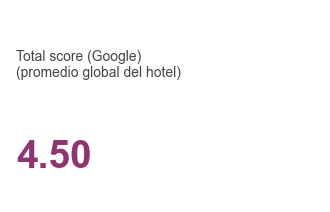

In [14]:
if "totalScore" in df_eda.columns:
    val = df_eda["totalScore"].dropna().iloc[0] if df_eda["totalScore"].notna().any() else np.nan
    fig, ax = plt.subplots(figsize=(4,2.5), facecolor="white")
    ax.axis("off")
    ax.text(0.02, 0.65, "Total score (Google)\n(promedio global del hotel)", fontsize=10, color="#444")
    ax.text(0.02, 0.18, f"{val:.2f}" if pd.notna(val) else "N/A", fontsize=28, weight="bold", color=FLARE[4])
    plt.show()
else:
    print("No está la columna 'totalScore' en df_eda.")


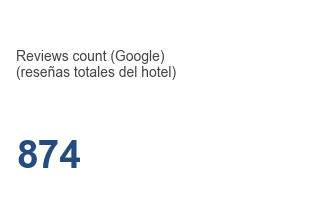

In [15]:
if "reviewsCount" in df_eda.columns:
    val = df_eda["reviewsCount"].dropna().iloc[0] if df_eda["reviewsCount"].notna().any() else np.nan
    fig, ax = plt.subplots(figsize=(4,2.5), facecolor="white")
    ax.axis("off")
    ax.text(0.02, 0.65, "Reviews count (Google)\n(reseñas totales del hotel)", fontsize=10, color="#444")
    ax.text(0.02, 0.18, f"{int(val):,}" if pd.notna(val) else "N/A", fontsize=28, weight="bold", color=CREST[5])
    plt.show()
else:
    print("No está la columna 'reviewsCount' en df_eda.")


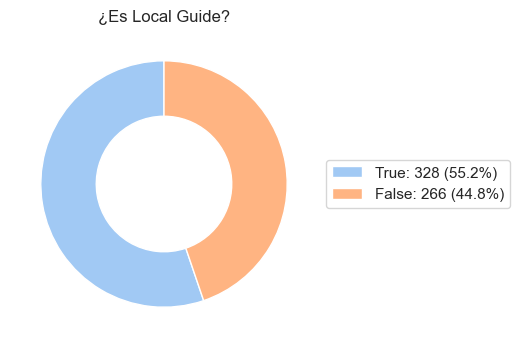

In [16]:
col = "isLocalGuide"
if col in df_eda.columns:
    counts = df_eda[col].value_counts(dropna=False)
    labels = [str(k) for k in counts.index]
    sizes  = counts.values
    colors = PASTEL[:len(labels)]

    fig, ax = plt.subplots(figsize=(4,4))
    wedges, texts = ax.pie(sizes, labels=None, startangle=90, colors=colors, wedgeprops=dict(width=0.45))
    ax.legend(wedges, [f"{l}: {v} ({v/sizes.sum():.1%})" for l,v in zip(labels, sizes)], loc="center left", bbox_to_anchor=(1, 0.5))
    ax.set_title("¿Es Local Guide?", fontsize=12)
    plt.show()
else:
    print("No está la columna 'isLocalGuide' en df_eda.")


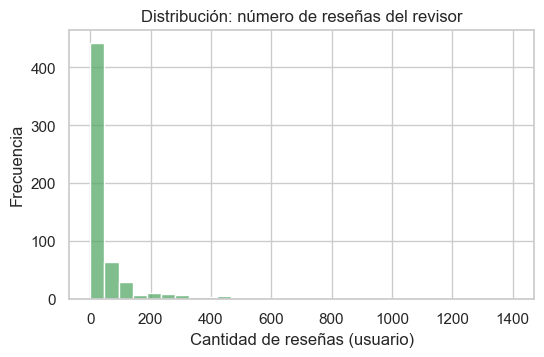

,value
count,591.000000
mean,52.649746
std,129.365325
min,0.000000
25%,1.000000
50%,9.000000
75%,46.500000
90%,130.000000
95%,272.000000
max,1402.000000


In [17]:
col = "reviewerNumberOfReviews"
if col in df_eda.columns:
    s = pd.to_numeric(df_eda[col], errors="coerce").dropna()
    fig, ax = plt.subplots(figsize=(6,3.5))
    sns.histplot(s, bins=30, ax=ax, color=DEEP[2])
    ax.set_title("Distribución: número de reseñas del revisor", fontsize=12)
    ax.set_xlabel("Cantidad de reseñas (usuario)"); ax.set_ylabel("Frecuencia")
    ax.set_yscale("linear")
    plt.show()

    # Estadísticos útiles
    desc = s.describe(percentiles=[.25,.5,.75,.9,.95]).to_frame("value")
    display(desc)
else:
    print("No está 'reviewerNumberOfReviews' en df_eda.")


C:\Users\Horse\AppData\Local\Temp\ipykernel_9960\3371877204.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top.values, y=top.index, ax=ax, palette=BRIGHTS)
C:\Users\Horse\AppData\Local\Temp\ipykernel_9960\3371877204.py:6: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.barplot(x=top.values, y=top.index, ax=ax, palette=BRIGHTS)


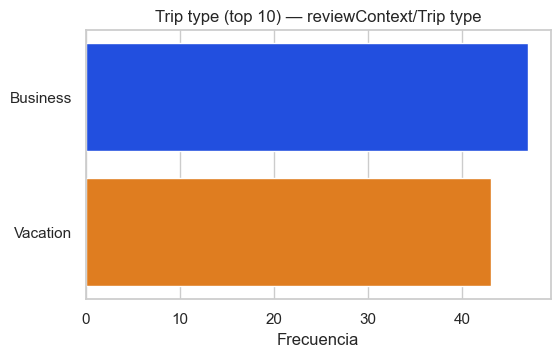

In [18]:
col = next((c for c in ctx_cols if "Trip type" in c or "Trip" in c), None)
if col and col in df_eda.columns:
    vc = df_eda[col].dropna().astype(str)
    top = vc.value_counts().head(10)
    fig, ax = plt.subplots(figsize=(6,3.5))
    sns.barplot(x=top.values, y=top.index, ax=ax, palette=BRIGHTS)
    ax.set_title(f"Trip type (top 10) — {col}", fontsize=12)
    ax.set_xlabel("Frecuencia"); ax.set_ylabel("")
    plt.show()
else:
    print("No encontré columna de Trip type en reviewContext/* (revisa ctx_cols).")


C:\Users\Horse\AppData\Local\Temp\ipykernel_9960\2948858020.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=vc.values, y=vc.index, ax=ax, palette=MUTED)
C:\Users\Horse\AppData\Local\Temp\ipykernel_9960\2948858020.py:6: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.barplot(x=vc.values, y=vc.index, ax=ax, palette=MUTED)


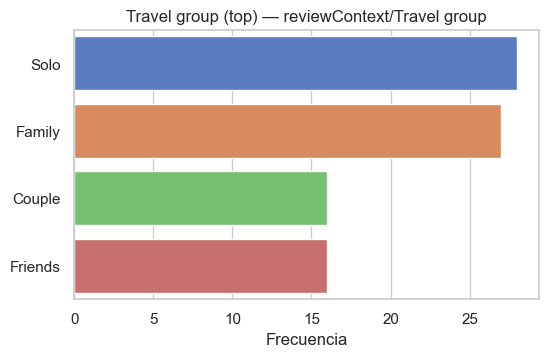

In [19]:
col = next((c for c in ctx_cols if "Travel group" in c or "group" in c), None)
if col and col in df_eda.columns:
    vc = df_eda[col].dropna().astype(str).value_counts()
    # Barras (recomendado)
    fig, ax = plt.subplots(figsize=(6,3.5))
    sns.barplot(x=vc.values, y=vc.index, ax=ax, palette=MUTED)
    ax.set_title(f"Travel group (top) — {col}")
    ax.set_xlabel("Frecuencia"); ax.set_ylabel("")
    plt.show()
else:
    print("No encontré columna de Travel group en reviewContext/*.")


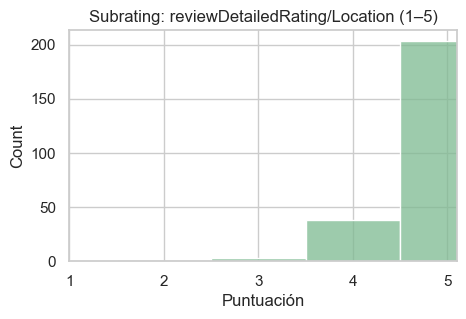

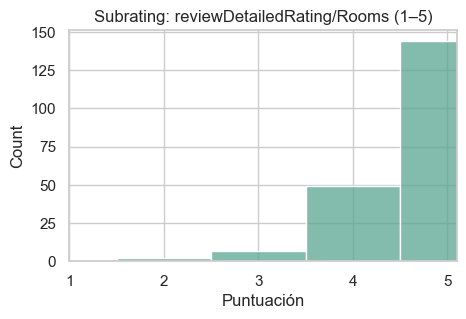

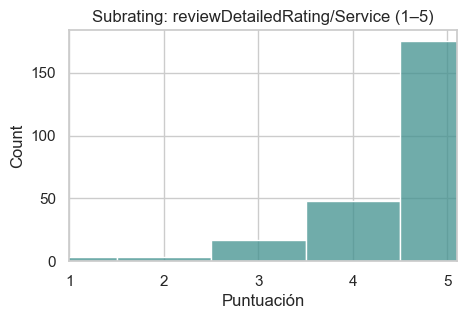

In [20]:
cols = [c for c in det_cols if any(k in c.lower() for k in ["location","rooms","service"])]
if cols:
    for i, c in enumerate(cols, 1):
        fig, ax = plt.subplots(figsize=(5,3))
        s = pd.to_numeric(df_eda[c], errors="coerce")
        sns.histplot(s, bins=[1,2,3,4,5,6], discrete=True, ax=ax, color=CREST[min(i, len(CREST))-1])
        ax.set_title(f"Subrating: {c} (1–5)")
        ax.set_xlabel("Puntuación"); ax.set_xlim(1,5.1)
        plt.show()
else:
    print("No encontré subratings en reviewDetailedRating/* (Location/Rooms/Service).")


C:\Users\Horse\AppData\Local\Temp\ipykernel_9960\3898780757.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=uni.values, y=uni.index, ax=ax, palette=CREST)
C:\Users\Horse\AppData\Local\Temp\ipykernel_9960\3898780757.py:5: UserWarning: 
The palette list has fewer values (6) than needed (20) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x=uni.values, y=uni.index, ax=ax, palette=CREST)


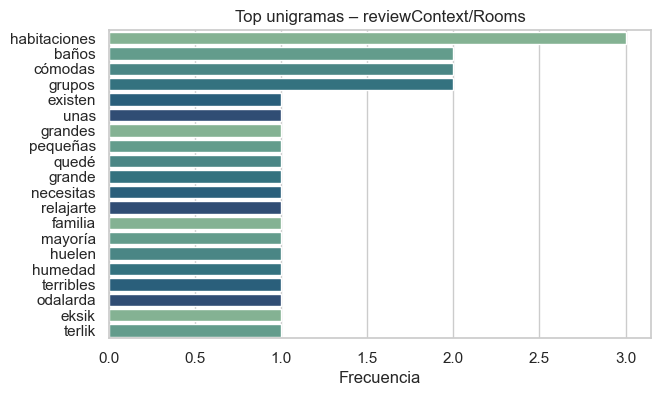

In [21]:
col = next((c for c in ctx_cols if "Rooms" in c), None)
if col and col in df_eda.columns:
    uni = top_unigrams(df_eda[col], topn=20)
    fig, ax = plt.subplots(figsize=(7,4))
    sns.barplot(x=uni.values, y=uni.index, ax=ax, palette=CREST)
    ax.set_title(f"Top unigramas – {col}")
    ax.set_xlabel("Frecuencia"); ax.set_ylabel("")
    plt.show()
else:
    print("No encontré columna reviewContext/Rooms.")


C:\Users\Horse\AppData\Local\Temp\ipykernel_9960\2689821224.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=uni.values, y=uni.index, ax=ax, palette=BRIGHTS)
C:\Users\Horse\AppData\Local\Temp\ipykernel_9960\2689821224.py:5: UserWarning: 
The palette list has fewer values (10) than needed (20) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x=uni.values, y=uni.index, ax=ax, palette=BRIGHTS)


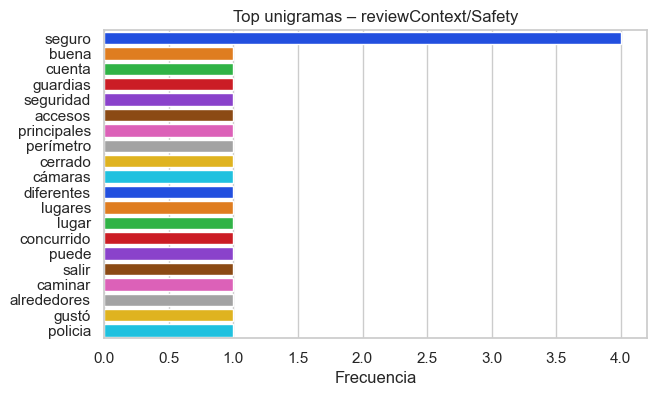

In [22]:
col = next((c for c in ctx_cols if "Safety" in c or "seguridad" in c.lower()), None)
if col and col in df_eda.columns:
    uni = top_unigrams(df_eda[col], topn=20)
    fig, ax = plt.subplots(figsize=(7,4))
    sns.barplot(x=uni.values, y=uni.index, ax=ax, palette=BRIGHTS)
    ax.set_title(f"Top unigramas – {col}")
    ax.set_xlabel("Frecuencia"); ax.set_ylabel("")
    plt.show()
else:
    print("No encontré columna de Safety en reviewContext/*.")


C:\Users\Horse\AppData\Local\Temp\ipykernel_9960\2393310856.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=uni.values, y=uni.index, ax=ax, palette=PASTEL)
C:\Users\Horse\AppData\Local\Temp\ipykernel_9960\2393310856.py:5: UserWarning: 
The palette list has fewer values (10) than needed (20) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x=uni.values, y=uni.index, ax=ax, palette=PASTEL)


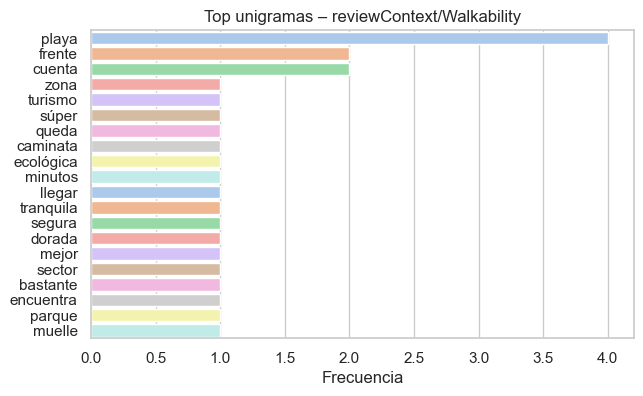

In [23]:
col = next((c for c in ctx_cols if "Walkability" in c or "walk" in c.lower()), None)
if col and col in df_eda.columns:
    uni = top_unigrams(df_eda[col], topn=20)
    fig, ax = plt.subplots(figsize=(7,4))
    sns.barplot(x=uni.values, y=uni.index, ax=ax, palette=PASTEL)
    ax.set_title(f"Top unigramas – {col}")
    ax.set_xlabel("Frecuencia"); ax.set_ylabel("")
    plt.show()
else:
    print("No encontré columna de Walkability en reviewContext/*.")


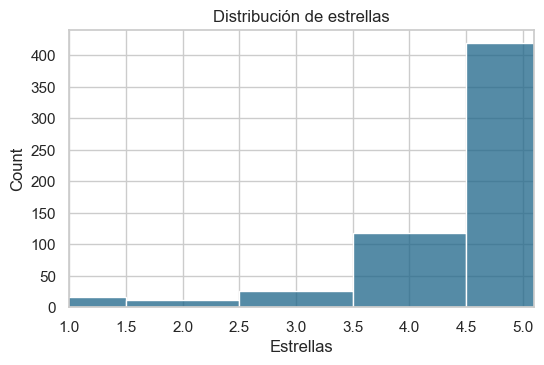

C:\Users\Horse\AppData\Local\Temp\ipykernel_9960\1239739607.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=vc.index, y=vc.values, palette=FLARE, ax=ax)
C:\Users\Horse\AppData\Local\Temp\ipykernel_9960\1239739607.py:10: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  sns.barplot(x=vc.index, y=vc.values, palette=FLARE, ax=ax)


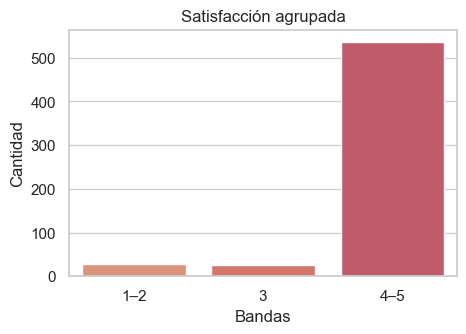

In [24]:
if "stars" in df_sent.columns:
    s = pd.to_numeric(df_sent["stars"], errors="coerce").dropna()
    fig, ax = plt.subplots(figsize=(6,3.6))
    sns.histplot(s, bins=[1,2,3,4,5,6], discrete=True, color=CREST[4], ax=ax)
    ax.set_title("Distribución de estrellas"); ax.set_xlabel("Estrellas"); ax.set_xlim(1,5.1); plt.show()

    band = pd.cut(s, bins=[0,2,3,5], labels=["1–2","3","4–5"], include_lowest=True)
    vc = band.value_counts().reindex(["1–2","3","4–5"]).fillna(0)
    fig, ax = plt.subplots(figsize=(5,3.2))
    sns.barplot(x=vc.index, y=vc.values, palette=FLARE, ax=ax)
    ax.set_title("Satisfacción agrupada"); ax.set_xlabel("Bandas"); ax.set_ylabel("Cantidad"); plt.show()
else:
    print("No está 'stars' en df_sent.")


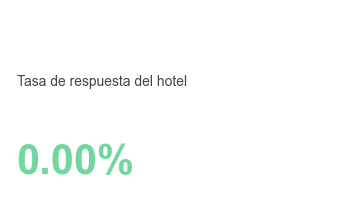

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

has_cols = {"responseFromOwnerText","responseFromOwnerDate"}
if has_cols.issubset(df_eda.columns) and "publishedAtDate" in df_sent.columns:
    # --- Tasa de respuesta ---
    tasa = (df_eda["responseFromOwnerText"].notna().mean() * 100).round(2)

    fig, ax = plt.subplots(figsize=(4.2, 2.6), facecolor="white")
    ax.axis("off")
    ax.text(0.02, 0.62, "Tasa de respuesta del hotel", fontsize=10, color="#444")
    ax.text(0.02, 0.18, f"{tasa:.2f}%", fontsize=30, weight="bold", color="#72d6a0")
    plt.show()

    # --- Delay (días): solo si hay al menos una respuesta ---
    pub  = pd.to_datetime(df_sent["publishedAtDate"], errors="coerce", utc=True)
    resp = pd.to_datetime(df_eda["responseFromOwnerDate"], errors="coerce", utc=True)

    tmp = pd.DataFrame({"publishedAtDate": pub, "responseFromOwnerDate": resp}).dropna()
    if tmp.empty:
        print("No hay respuestas del dueño registradas → no se puede calcular el tiempo de respuesta.")
    else:
        delay = (tmp["responseFromOwnerDate"] - tmp["publishedAtDate"]).dt.days
        delay = delay[delay >= 0]  # por si hay registros invertidos

        if delay.empty:
            print("No hay delays válidos (>=0 días).")
        else:
            fig, ax = plt.subplots(figsize=(5.5, 3.6))
            sns.boxplot(x=delay, color="#4C78A8", ax=ax)
            ax.set_title("Tiempo de respuesta (días)")
            ax.set_xlabel("Días")
            plt.show()
else:
    print("Faltan columnas:", (has_cols - set(df_eda.columns)) | ({"publishedAtDate"} - set(df_sent.columns)))


C:\Users\Horse\AppData\Local\Temp\ipykernel_9960\4044649846.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=uni.values, y=uni.index, palette=ROCKET, ax=ax)
C:\Users\Horse\AppData\Local\Temp\ipykernel_9960\4044649846.py:5: UserWarning: 
The palette list has fewer values (6) than needed (20) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x=uni.values, y=uni.index, palette=ROCKET, ax=ax)


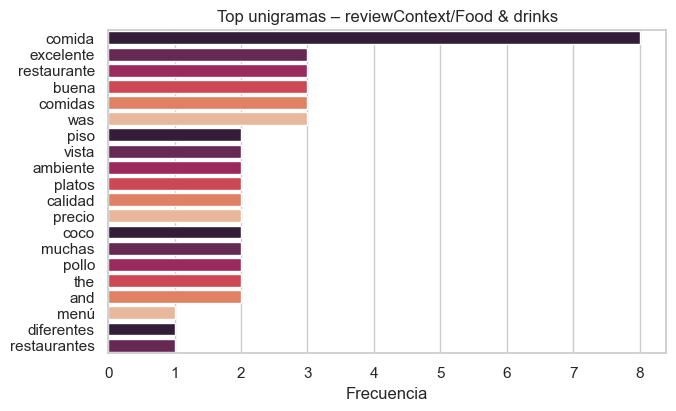

C:\Users\Horse\AppData\Local\Temp\ipykernel_9960\4044649846.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=bi.values, y=bi.index, palette=FLARE, ax=ax)
C:\Users\Horse\AppData\Local\Temp\ipykernel_9960\4044649846.py:11: UserWarning: 
The palette list has fewer values (6) than needed (20) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x=bi.values, y=bi.index, palette=FLARE, ax=ax)


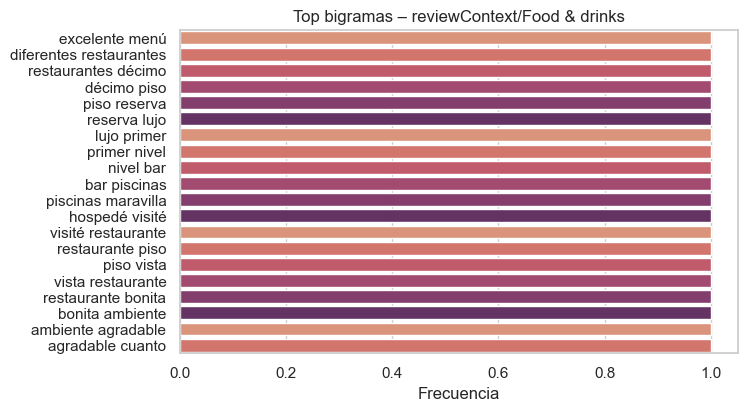

In [26]:
col = next((c for c in CTX if "Food" in c or "drinks" in c or "Comida" in c), None)
if col:
    uni = top_unigrams(df_eda[col], topn=20)
    fig, ax = plt.subplots(figsize=(7.2,4.2))
    sns.barplot(x=uni.values, y=uni.index, palette=ROCKET, ax=ax)
    ax.set_title(f"Top unigramas – {col}"); ax.set_xlabel("Frecuencia"); ax.set_ylabel("")
    plt.show()

    bi = top_bigrams(df_eda[col], topn=20)
    fig, ax = plt.subplots(figsize=(7.2,4.2))
    sns.barplot(x=bi.values, y=bi.index, palette=FLARE, ax=ax)
    ax.set_title(f"Top bigramas – {col}"); ax.set_xlabel("Frecuencia"); ax.set_ylabel("")
    plt.show()
else:
    print("No encontré reviewContext/Food & drinks.")


C:\Users\Horse\AppData\Local\Temp\ipykernel_9960\1490078413.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=uni.values, y=uni.index, palette=DEEP, ax=ax)
C:\Users\Horse\AppData\Local\Temp\ipykernel_9960\1490078413.py:5: UserWarning: 
The palette list has fewer values (10) than needed (20) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x=uni.values, y=uni.index, palette=DEEP, ax=ax)


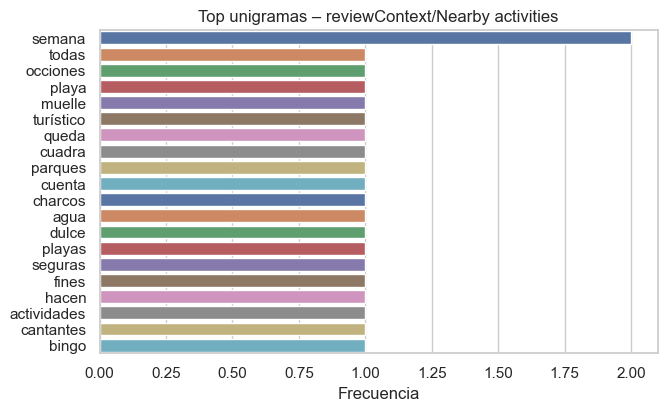

C:\Users\Horse\AppData\Local\Temp\ipykernel_9960\1490078413.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=bi.values, y=bi.index, palette=PASTEL, ax=ax)
C:\Users\Horse\AppData\Local\Temp\ipykernel_9960\1490078413.py:11: UserWarning: 
The palette list has fewer values (10) than needed (19) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x=bi.values, y=bi.index, palette=PASTEL, ax=ax)


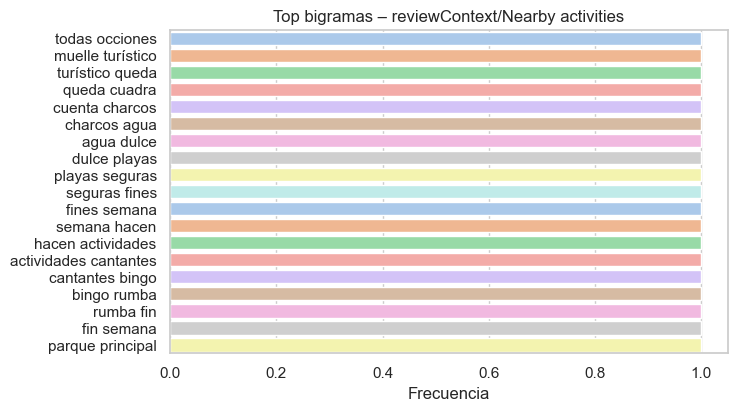

In [27]:
col = next((c for c in CTX if "Nearby" in c or "activit" in c.lower()), None)
if col:
    uni = top_unigrams(df_eda[col], topn=20)
    fig, ax = plt.subplots(figsize=(7.2,4.2))
    sns.barplot(x=uni.values, y=uni.index, palette=DEEP, ax=ax)
    ax.set_title(f"Top unigramas – {col}"); ax.set_xlabel("Frecuencia"); ax.set_ylabel("")
    plt.show()

    bi = top_bigrams(df_eda[col], topn=20)
    fig, ax = plt.subplots(figsize=(7.2,4.2))
    sns.barplot(x=bi.values, y=bi.index, palette=PASTEL, ax=ax)
    ax.set_title(f"Top bigramas – {col}"); ax.set_xlabel("Frecuencia"); ax.set_ylabel("")
    plt.show()
else:
    print("No encontré reviewContext/Nearby activities.")


In [28]:
col = next((c for c in CTX if "Hotel highlights" in c or "highlight" in c.lower() or "Noteworthy" in c), None)
if col:
    vc = df_eda[col].dropna().astype(str).value_counts().head(15)
    display(vc.to_frame("frecuencia"))
else:
    print("No encontré reviewContext/Hotel highlights o Noteworthy details.")


,frecuencia
reviewContext/Hotel highlights,
Great view,22
Quiet,8
"Great view, Quiet",8
Luxury,7
"Great view, Quiet, Great value",4
"Luxury, Great view",3
"Luxury, Great view, Romantic, Quiet, Kid-friendly, Great value",2
"Luxury, Great view, Quiet, Great value",2
High-tech,2


C:\Users\Horse\AppData\Local\Temp\ipykernel_9960\286417151.py:8: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  t = t[t["publishedAtDate"].notna()].assign(ym=lambda d: d["publishedAtDate"].dt.to_period("M"))


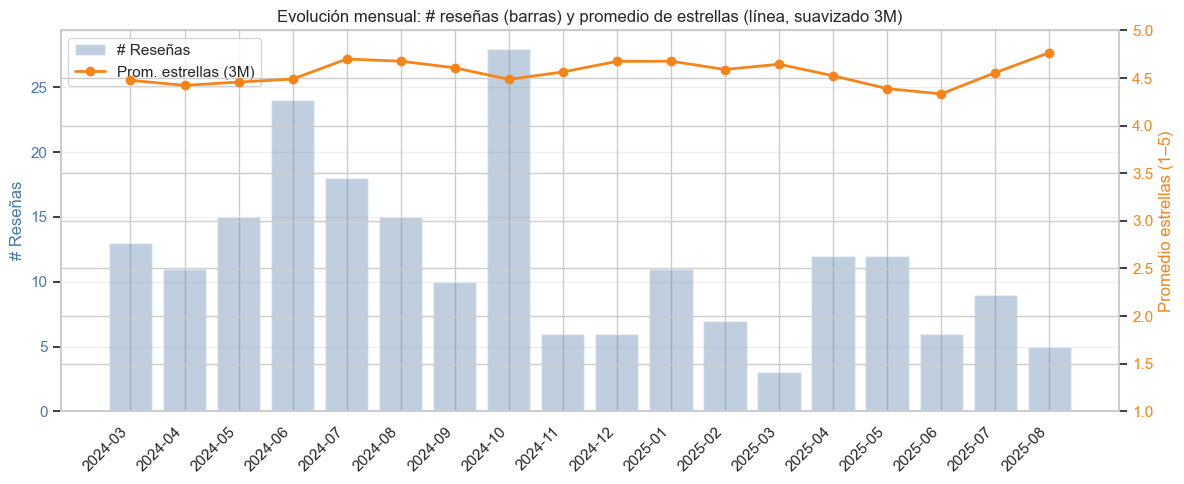

In [29]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt

# === parámetro: cuántos meses recientes mostrar ===
LAST_N_MONTHS = 18   # pon 12 para último año, o None para todos

t = df_sent.copy()
t["publishedAtDate"] = pd.to_datetime(t["publishedAtDate"], errors="coerce", utc=True)
t = t[t["publishedAtDate"].notna()].assign(ym=lambda d: d["publishedAtDate"].dt.to_period("M"))

# agrega por mes
g = (t.groupby("ym")
       .agg(reseñas=("stars","size"), avg_stars=("stars","mean"))
       .sort_index())

# rellena meses faltantes para que la línea sea continua
full_idx = pd.period_range(g.index.min(), g.index.max(), freq="M")
g = g.reindex(full_idx)
g["reseñas"] = g["reseñas"].fillna(0).astype(int)

# suaviza el promedio (rolling 3 meses) para que se vea mejor
g["avg_stars_smooth"] = g["avg_stars"].rolling(3, min_periods=1).mean()

# recorta a últimos N meses si aplica
if LAST_N_MONTHS:
    g = g.tail(LAST_N_MONTHS)

# eje X como posiciones + etiquetas YYYY-MM
x = np.arange(len(g))
labels = [p.strftime("%Y-%m") for p in g.index]

fig, ax1 = plt.subplots(figsize=(12, 5))

# barras: # reseñas (eje izquierdo)
ax1.bar(x, g["reseñas"], color="#4C78A8", alpha=0.35, label="# Reseñas")
ax1.set_ylabel("# Reseñas", color="#4C78A8"); ax1.tick_params(axis="y", labelcolor="#4C78A8")

# línea: promedio de estrellas (eje derecho)
ax2 = ax1.twinx()
ax2.plot(x, g["avg_stars_smooth"], marker="o", lw=2, color="#F58518", label="Prom. estrellas (3M)")
ax2.set_ylabel("Promedio estrellas (1–5)", color="#F58518"); ax2.tick_params(axis="y", labelcolor="#F58518")
ax2.set_ylim(1, 5)

# etiquetas del eje X: muestra ~12 para que no se encime
ax1.set_xticks(x)
step = max(1, len(labels)//12)
ax1.set_xticklabels([lbl if i % step == 0 else "" for i,lbl in enumerate(labels)], rotation=45, ha="right")

ax1.set_title("Evolución mensual: # reseñas (barras) y promedio de estrellas (línea, suavizado 3M)")

# leyenda combinada
lines, labs = [], []
for ax in (ax1, ax2):
    L = ax.get_legend_handles_labels()
    lines += L[0]; labs += L[1]
ax1.legend(lines, labs, loc="upper left", frameon=True)

ax1.grid(True, axis="y", alpha=.3)
plt.tight_layout(); plt.show()
